# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)
- [Visualization used in the paper](#paper)

# Initialization code

In [2]:
library("ggsci")
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)
library(viridis)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/microservices_simgrid_reproductibility/comparison"

<a id='description'></a>
# 1st scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 1 computing node. The datasource will send requests to it with various work amounts (loop iterations), the computing node once finishing the request sends the result to the Sink node, which does nothing but some logging.

The experiment lasts for 5 minutes and is repeated 5 times for each work amount to limit random effects.

We execute the experiment with two different parallel degrees: 5 and 10.

Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
nbIters: start=1, end=80000001, iter=2000000
Samples: 1
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's paravance cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `scenario=1 parD=10 suffix=testm hostLogPath=${HOME}/logs_expe/goLogs/0607_par10test logDir=/logs/ tsFile=/go/src/app/timestamps/default5TimeStamps.csv start=1 end=80000001 iter=10000000 nbSamples=1 durIter=360 bash launchPar.sh`

Set `parD` to either 5 or 10.

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/microbenchmarks/reprod_calib_2021-04-09_09-08-08/`
- For the execution: `results_reprod/microbenchmarks/reprod_scenario1_2021-04-09_09-08-08/`


## Synthetic Loads


We use 2 synthetic workloads to perform our experiments:

- Calibration workload: one request triggered every 3 seconds for 5 minutes (300 seconds)
- Execution workload: varying workload generated using LIMBO, with 3 spikes


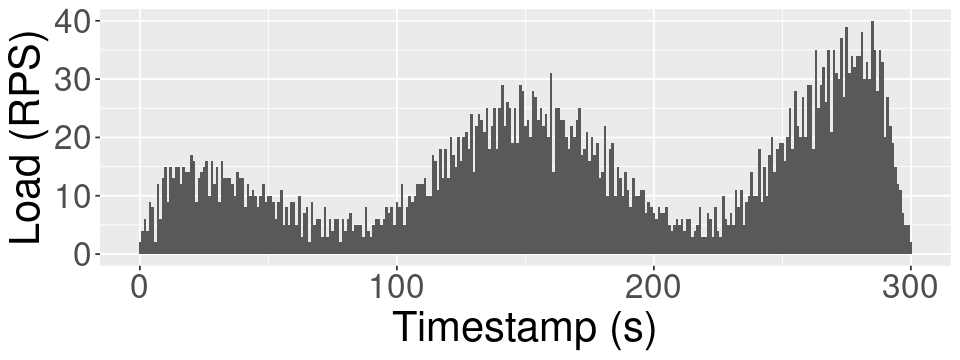

In [3]:
options(repr.plot.width=15, repr.plot.height=7)
options(repr.plot.width=8, repr.plot.height=3)
tsData <- read.csv("./results_reprod/microbenchmarks/tsload.csv")

colnames(tsData) <- c("timestamp")

ggplot(tsData, aes(x=tsData[,1])) +
    geom_histogram(binwidth=1) +
    theme(legend.position = "bottom", text = element_text(size = 25))+
    labs(y="Load (RPS)", x="Timestamp (s)", color="")
    #ggtitle("Execution workload generated with LIMBO")


ggsave("plotMicrobenchLoad.pdf", width=8, height=3)

# Load Datasets

In [26]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("results_reprod/microbenchmarks/0607_calib/1_aggrResults_1-5000000-100000000_2.csv"))
summary(data_calibration)

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9

data_calibration_sg <- as_tibble(read.csv("results_reprod/microbenchmarks/sg_cal_scenario1.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
#data_SG_load <- as_tibble(read.csv("results_reprod/microbenchmarks/sg_load_scenario1.csv"))
#data_load_RW <- as_tibble(read.csv("results_reprod/microbenchmarks/reprod_scenario1_2021-04-09_09-08-08/1_aggrResults_1-2000000-80000001_4.csv"))
#data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
#data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9



 serviceName            nbIter           timestamp          totDurInServ     
 Length:4000        Min.   :       1   Min.   :0.000e+00   Min.   :    1703  
 Class :character   1st Qu.:23750001   1st Qu.:7.426e+10   1st Qu.: 8050973  
 Mode  :character   Median :47500001   Median :1.485e+11   Median :15921993  
                    Mean   :47500001   Mean   :1.485e+11   Mean   :15259013  
                    3rd Qu.:71250001   3rd Qu.:2.228e+11   3rd Qu.:23748915  
                    Max.   :95000001   Max.   :2.970e+11   Max.   :36250374  
   computeDur          parExec       totReqProcessed   scenario        
 Min.   :     323   Min.   :0.0000   Min.   : 0.00   Length:4000       
 1st Qu.: 8049176   1st Qu.:0.0000   1st Qu.:24.75   Class :character  
 Median :15919570   Median :1.0000   Median :49.50   Mode  :character  
 Mean   :15256573   Mean   :0.5188   Mean   :49.50                     
 3rd Qu.:23747212   3rd Qu.:1.0000   3rd Qu.:74.25                     
 Max.   :36239898   Ma

       ts              qArr        instArr       startEx        endEx       
 Min.   :  4.00   Min.   :  4   Min.   :  4   Min.   :  4   Min.   :  4.00  
 1st Qu.: 76.02   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76.02  
 Median :151.02   Median :151   Median :151   Median :151   Median :151.02  
 Mean   :151.02   Mean   :151   Mean   :151   Mean   :151   Mean   :151.02  
 3rd Qu.:226.01   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226.01  
 Max.   :298.03   Max.   :298   Max.   :298   Max.   :298   Max.   :298.03  
     flops              serv          
 Min.   :  234400   Length:2079       
 1st Qu.: 8141900   Class :character  
 Median :16049400   Mode  :character  
 Mean   :16049400                     
 3rd Qu.:23956900                     
 Max.   :31864400                     

<a id='calibration'></a>
# Calibration Step

We execute the application with a very low load: 1 request every 3 seconds.
We launch this load with various amounts of work for the service. This provides us insights on the duration of an execution in the service when no-one is overloaded.

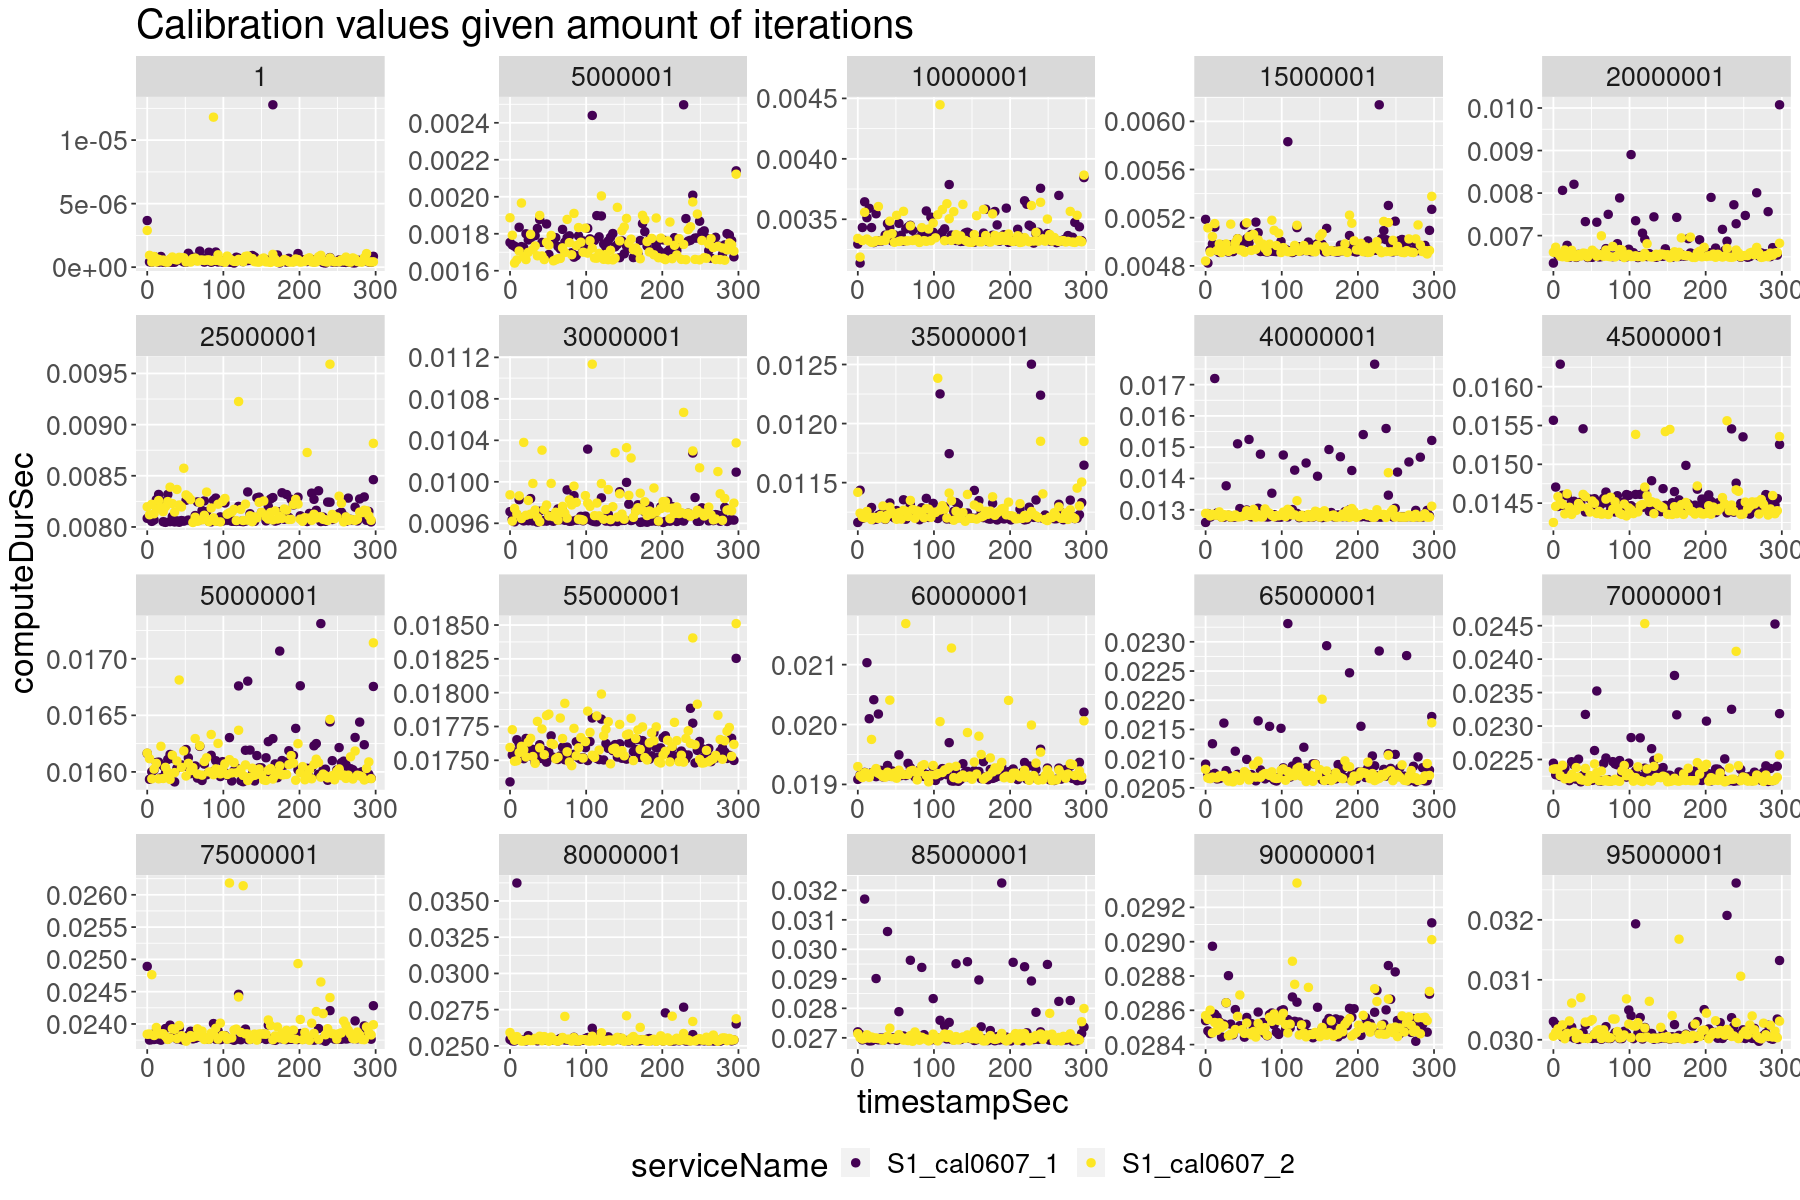

In [8]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

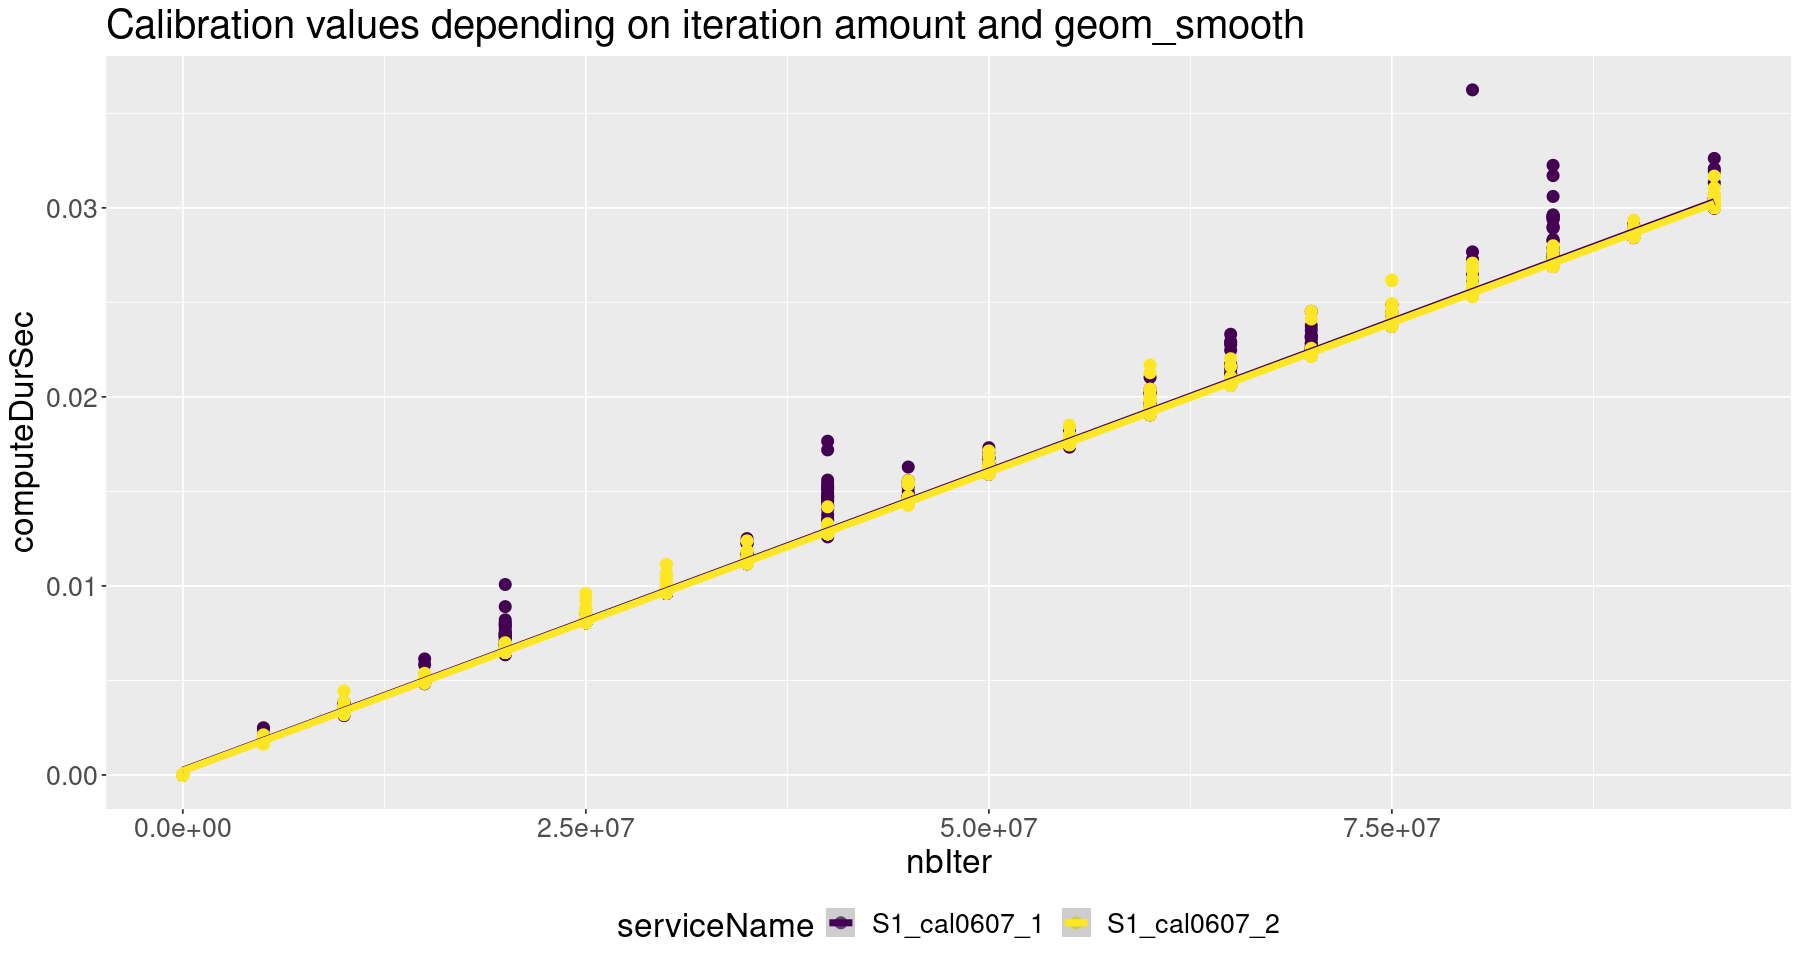

In [9]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [10]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0003043 -0.0001340 -0.0000711  0.0000087  0.0107050 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.344e-04  1.182e-05   19.82   <2e-16 ***
nbIter      3.163e-10  2.128e-13 1486.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.000388 on 3998 degrees of freedom
Multiple R-squared:  0.9982,	Adjusted R-squared:  0.9982 
F-statistic: 2.209e+06 on 1 and 3998 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.163*10**(-10)+2.344*10**(-4)``` 

## Utility function to obtain duration from nbIter

In [11]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.163*10**(-10)+2.344*10**(-4))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.0793094
[1] 0.1583844
[1] 0.2374594


## Calibration comparison between real world data and SimGrid

In [25]:
start=1
end=100000002
iter=5000000

nbIter_to_duration_to_SG(start, end, iter)

234400  1815900  3397400  4978900  6560400  8141900  9723400  11304900  12886400  14467900  16049400  17630900  19212400  20793900  22375400  23956900  25538400  27119900  28701400  30282900  31864400  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_cal_scenario1.csv
for i in 234400  1815900  3397400  4978900  6560400  8141900  9723400  11304900  12886400  14467900  16049400  17630900  19212400  20793900  22375400  23956900  25538400  27119900  28701400  30282900  31864400 
do
    echo "Calibration for iterAmount=$i"
    scenario=1 parDeg=1 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_cal_scenario1.csv
done
```

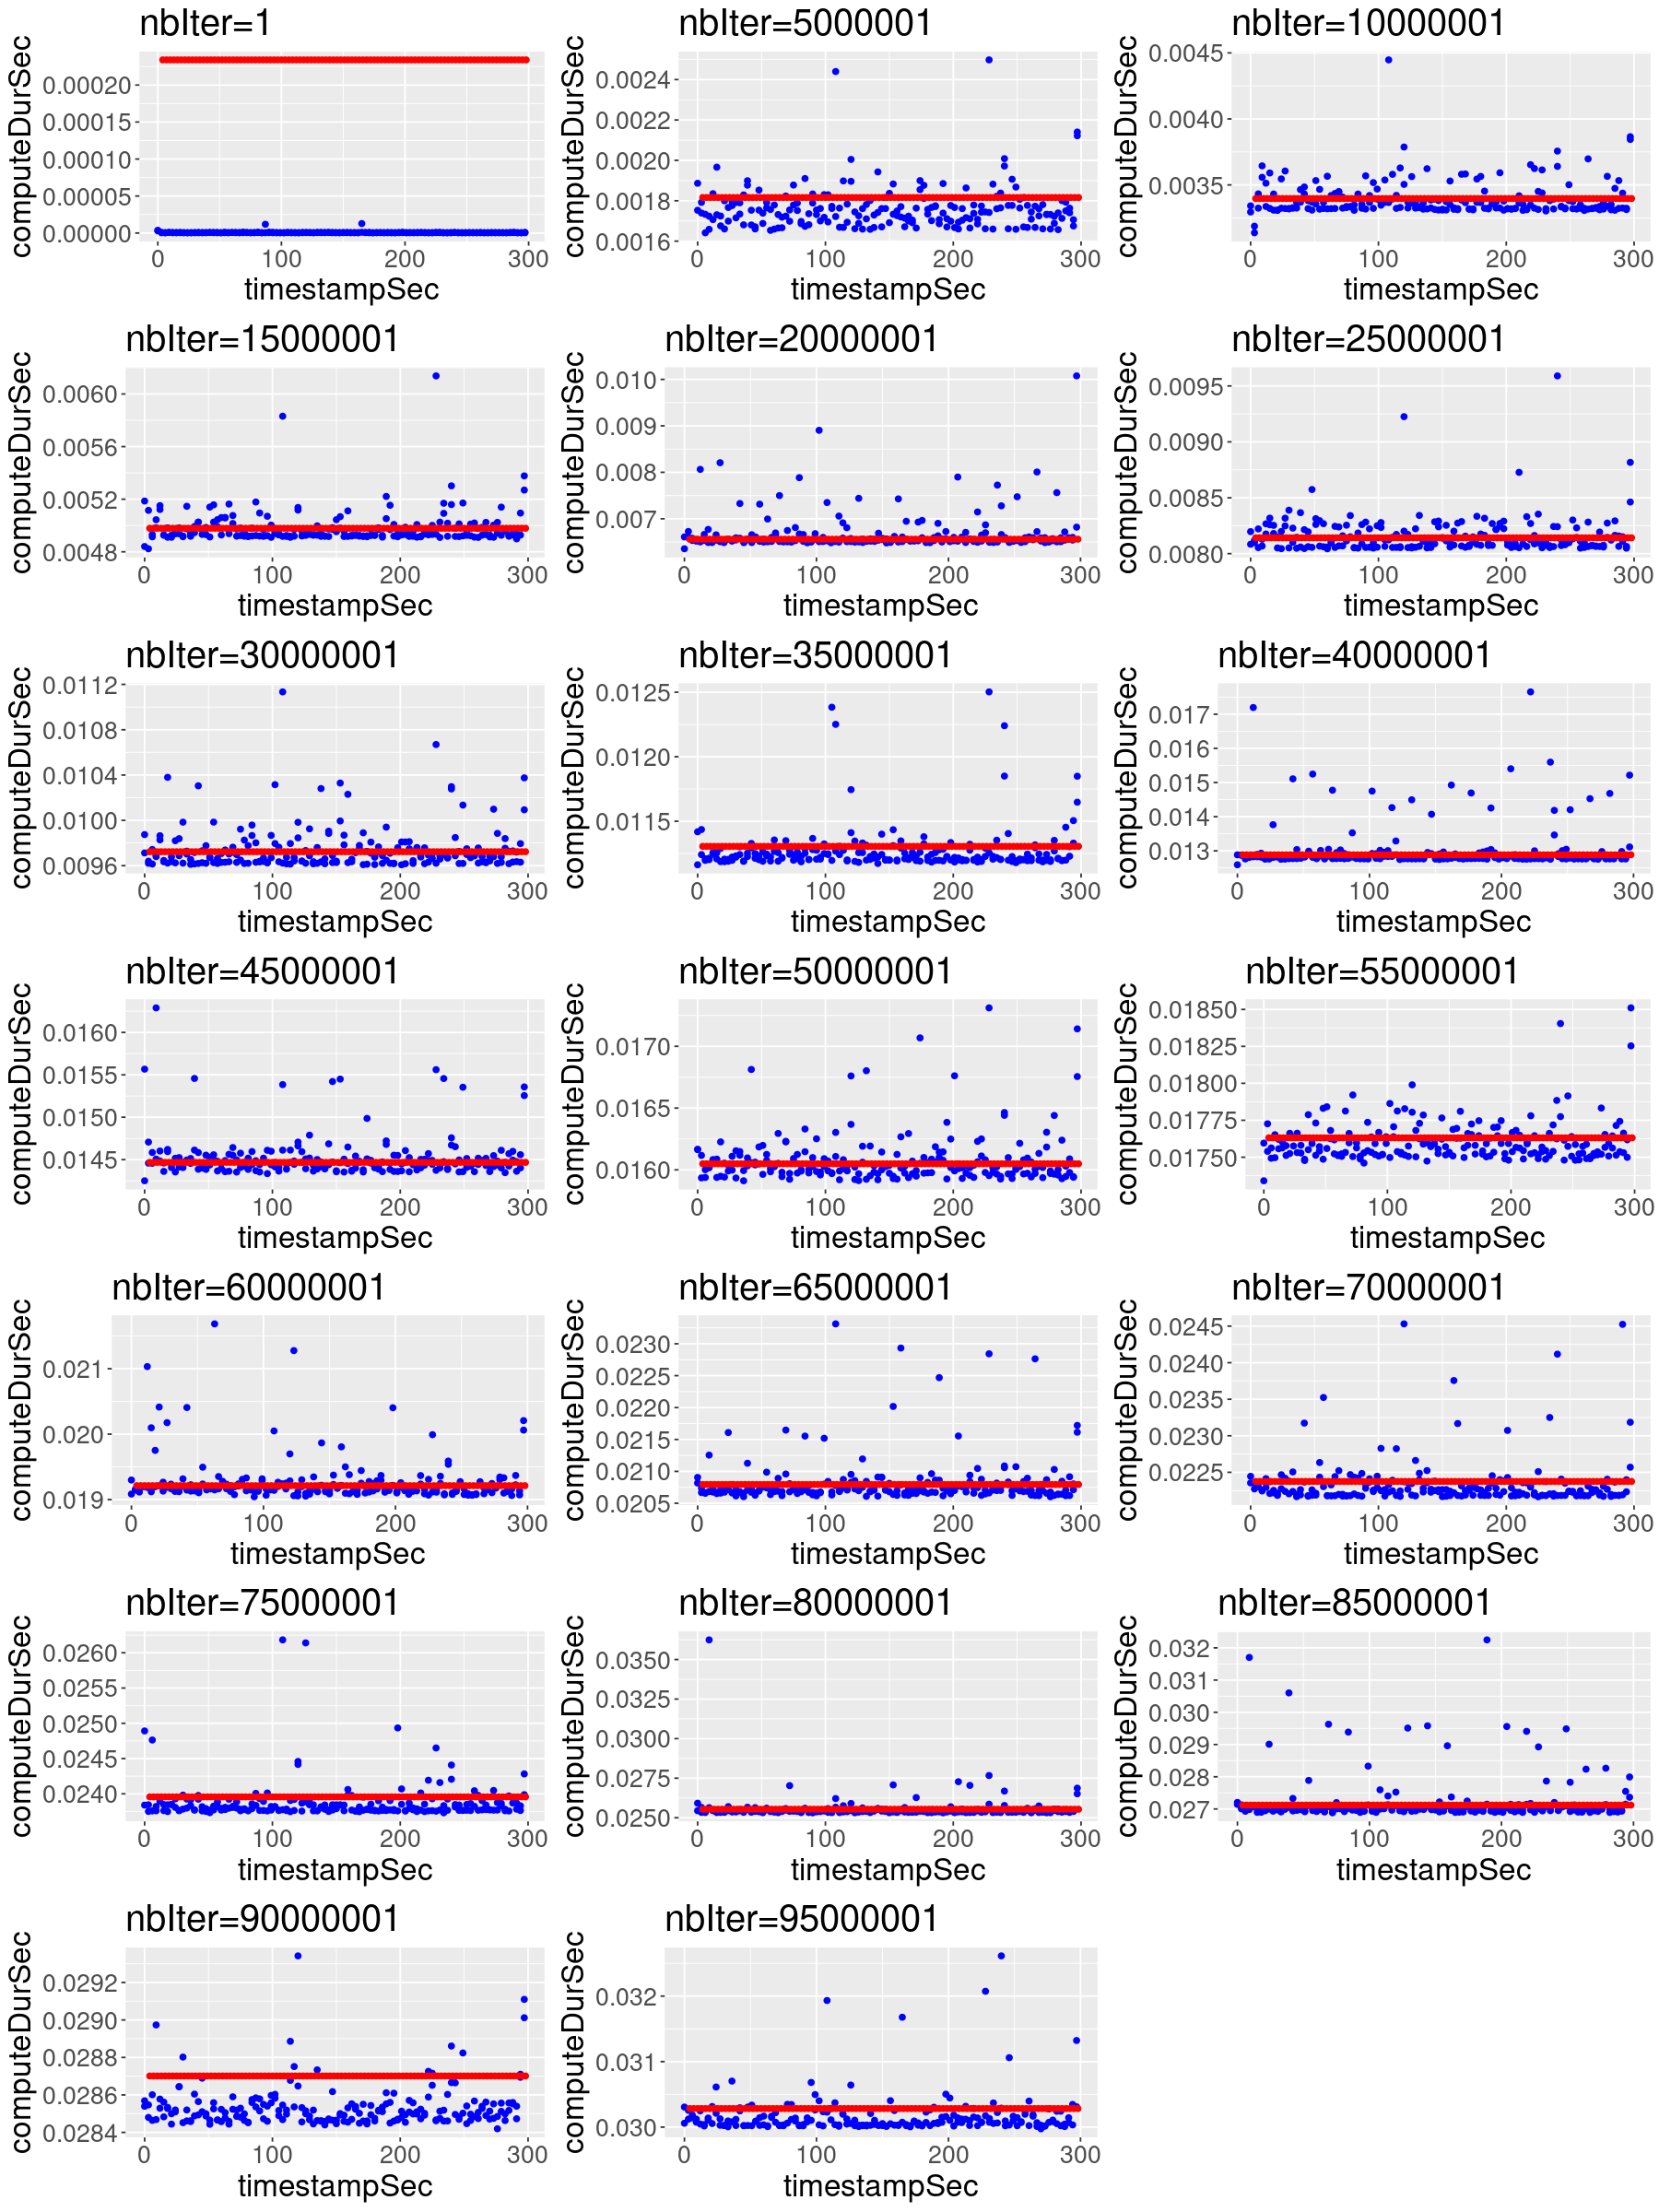

In [29]:


options(repr.plot.width=15, repr.plot.height=20)
P <- list()
for(i in seq(from=1, to=95000002, by=5000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

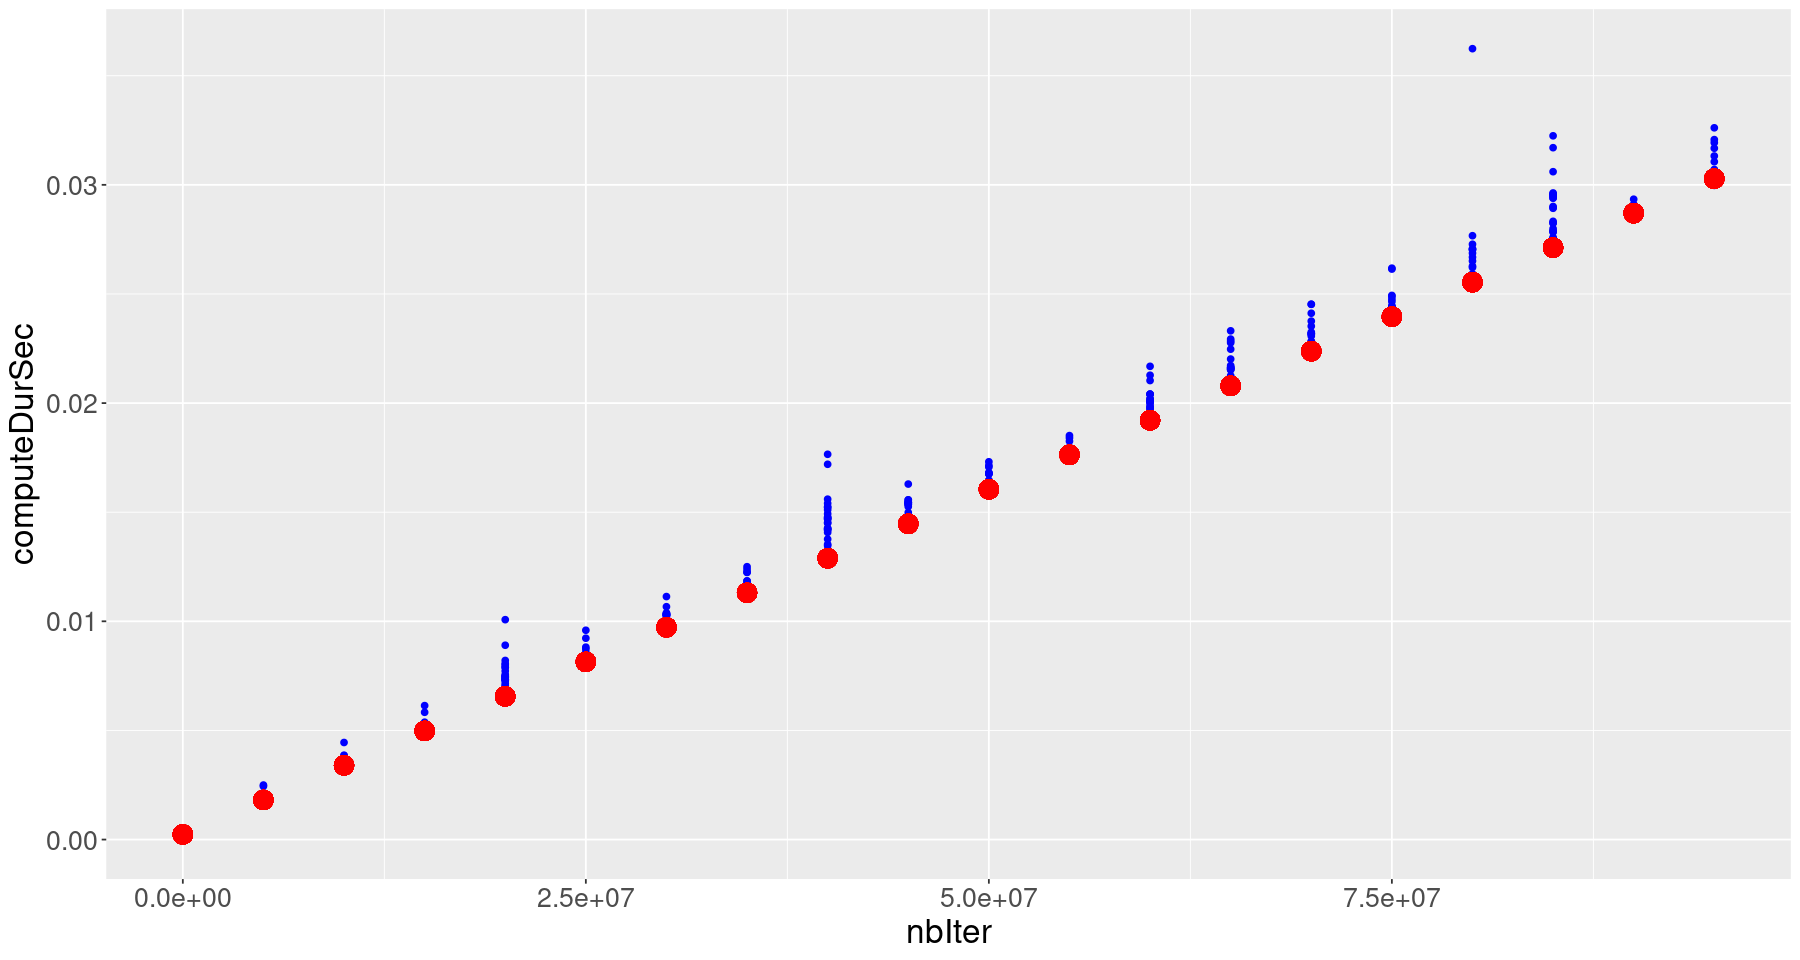

In [28]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=95000002, by=5000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

We observe that with our calibration, we obtain the same behavior with both our SimGrid model and real world values observed. This Shows the ability of our model to reproduce the duration of requests under a low load. In the next paragraph, we look at what happens when the load is dynamic, leading to a share of resources and queueing.

<a id='comparison'></a>
# Execution comparison

We execute the application under the dynamic load. We show results for 2 different parallel degrees (5 and 10) as well as different request costs. Some additional parameter combination data is available in the results_reprod directory.

In [30]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=100000001
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

234400  3397400  6560400  9723400  12886400  16049400  19212400  22375400  25538400  28701400  31864400  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario1.csv
for i in 234400  3397400  6560400  9723400  12886400  16049400  19212400  22375400  25538400  28701400  31864400  
do
    echo "Calibration for iterAmount=$i"
    scenario=1 parDeg=8 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario1.csv
done
```

## Maximum of 10 parallel requests

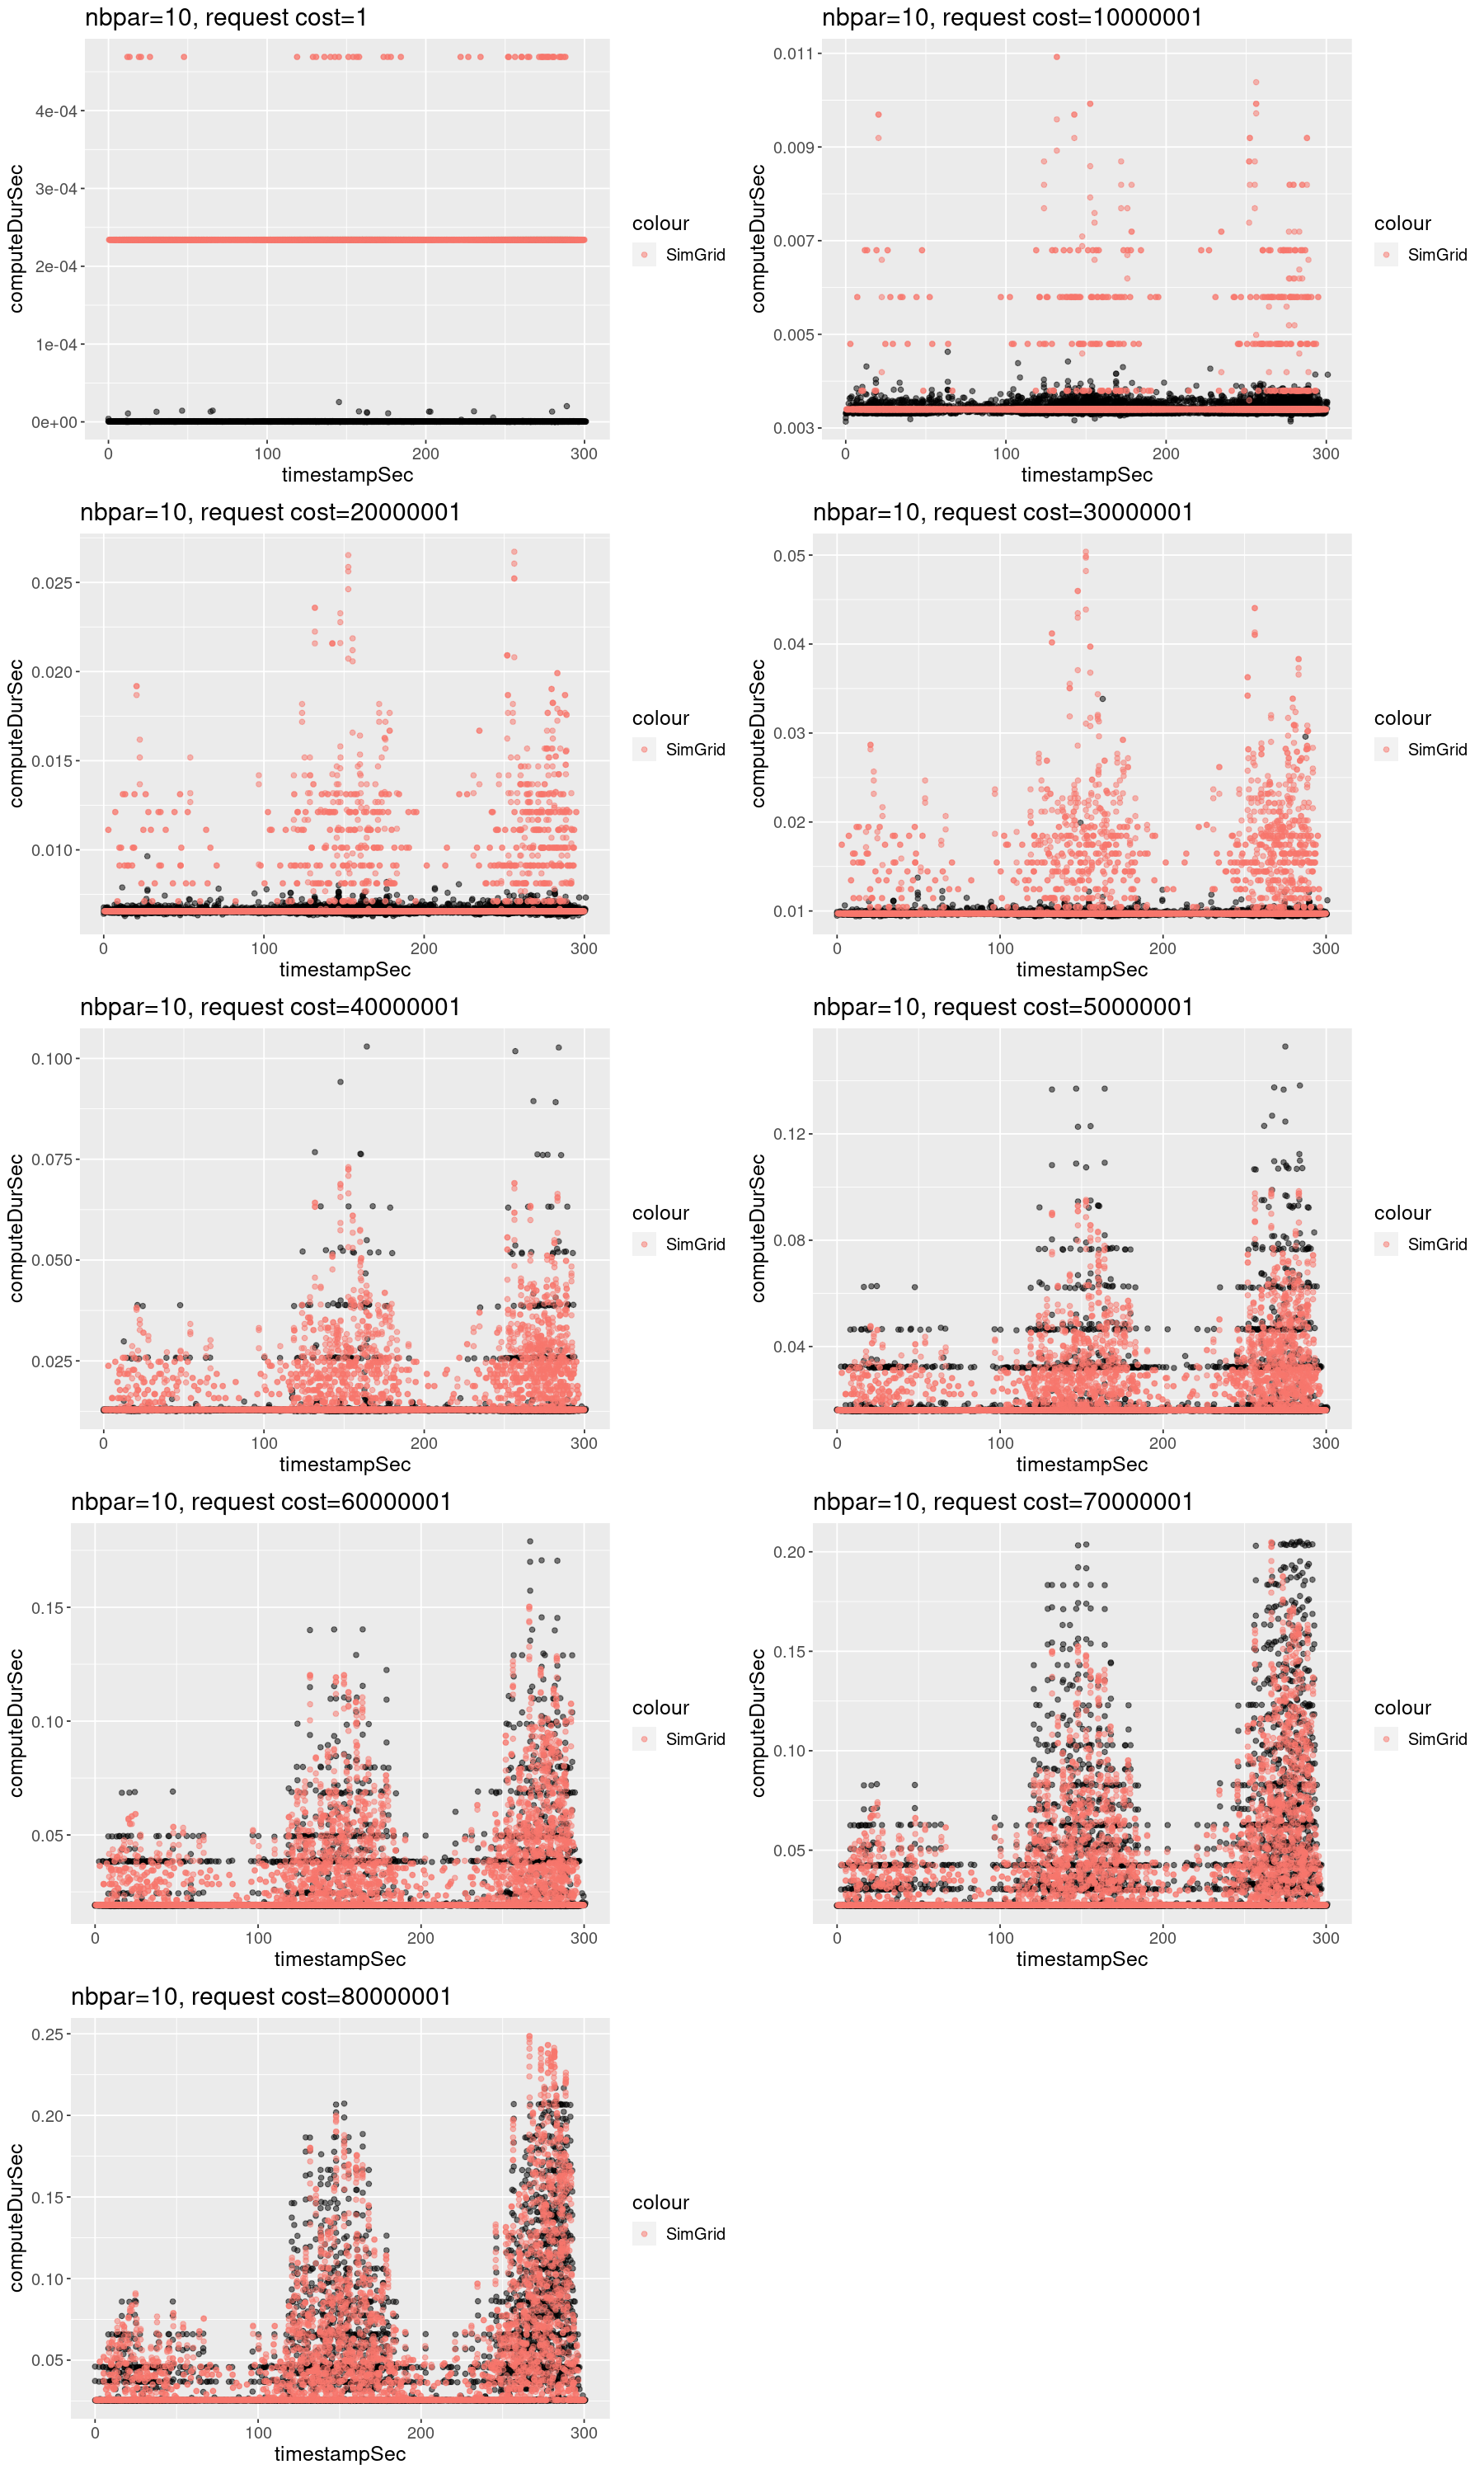

In [44]:

data_SG_load <- as_tibble(read.csv("results_reprod/microbenchmarks/sg_load_scenario1_par10.csv"))

data_load_RW <- as_tibble(read.csv("results_reprod/microbenchmarks//0607_par10test_1sample/1_aggrResults_1-10000000-80000001_1.csv"))

# preprocess to obtain timestamps as seconds instead of microseconds
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9

options(repr.plot.width=15, repr.plot.height=25)

P <- list()
for(i in seq(from=1, to=90000000, by=10000000)){
    tmpsg <- subset(data_SG_load, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec),alpha = 0.5)+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx, colour="SimGrid"),alpha = 0.5)+
        labs(title=sprintf("nbpar=10, request cost=%d",i))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=2))


## Maximum of 5 parallel requests

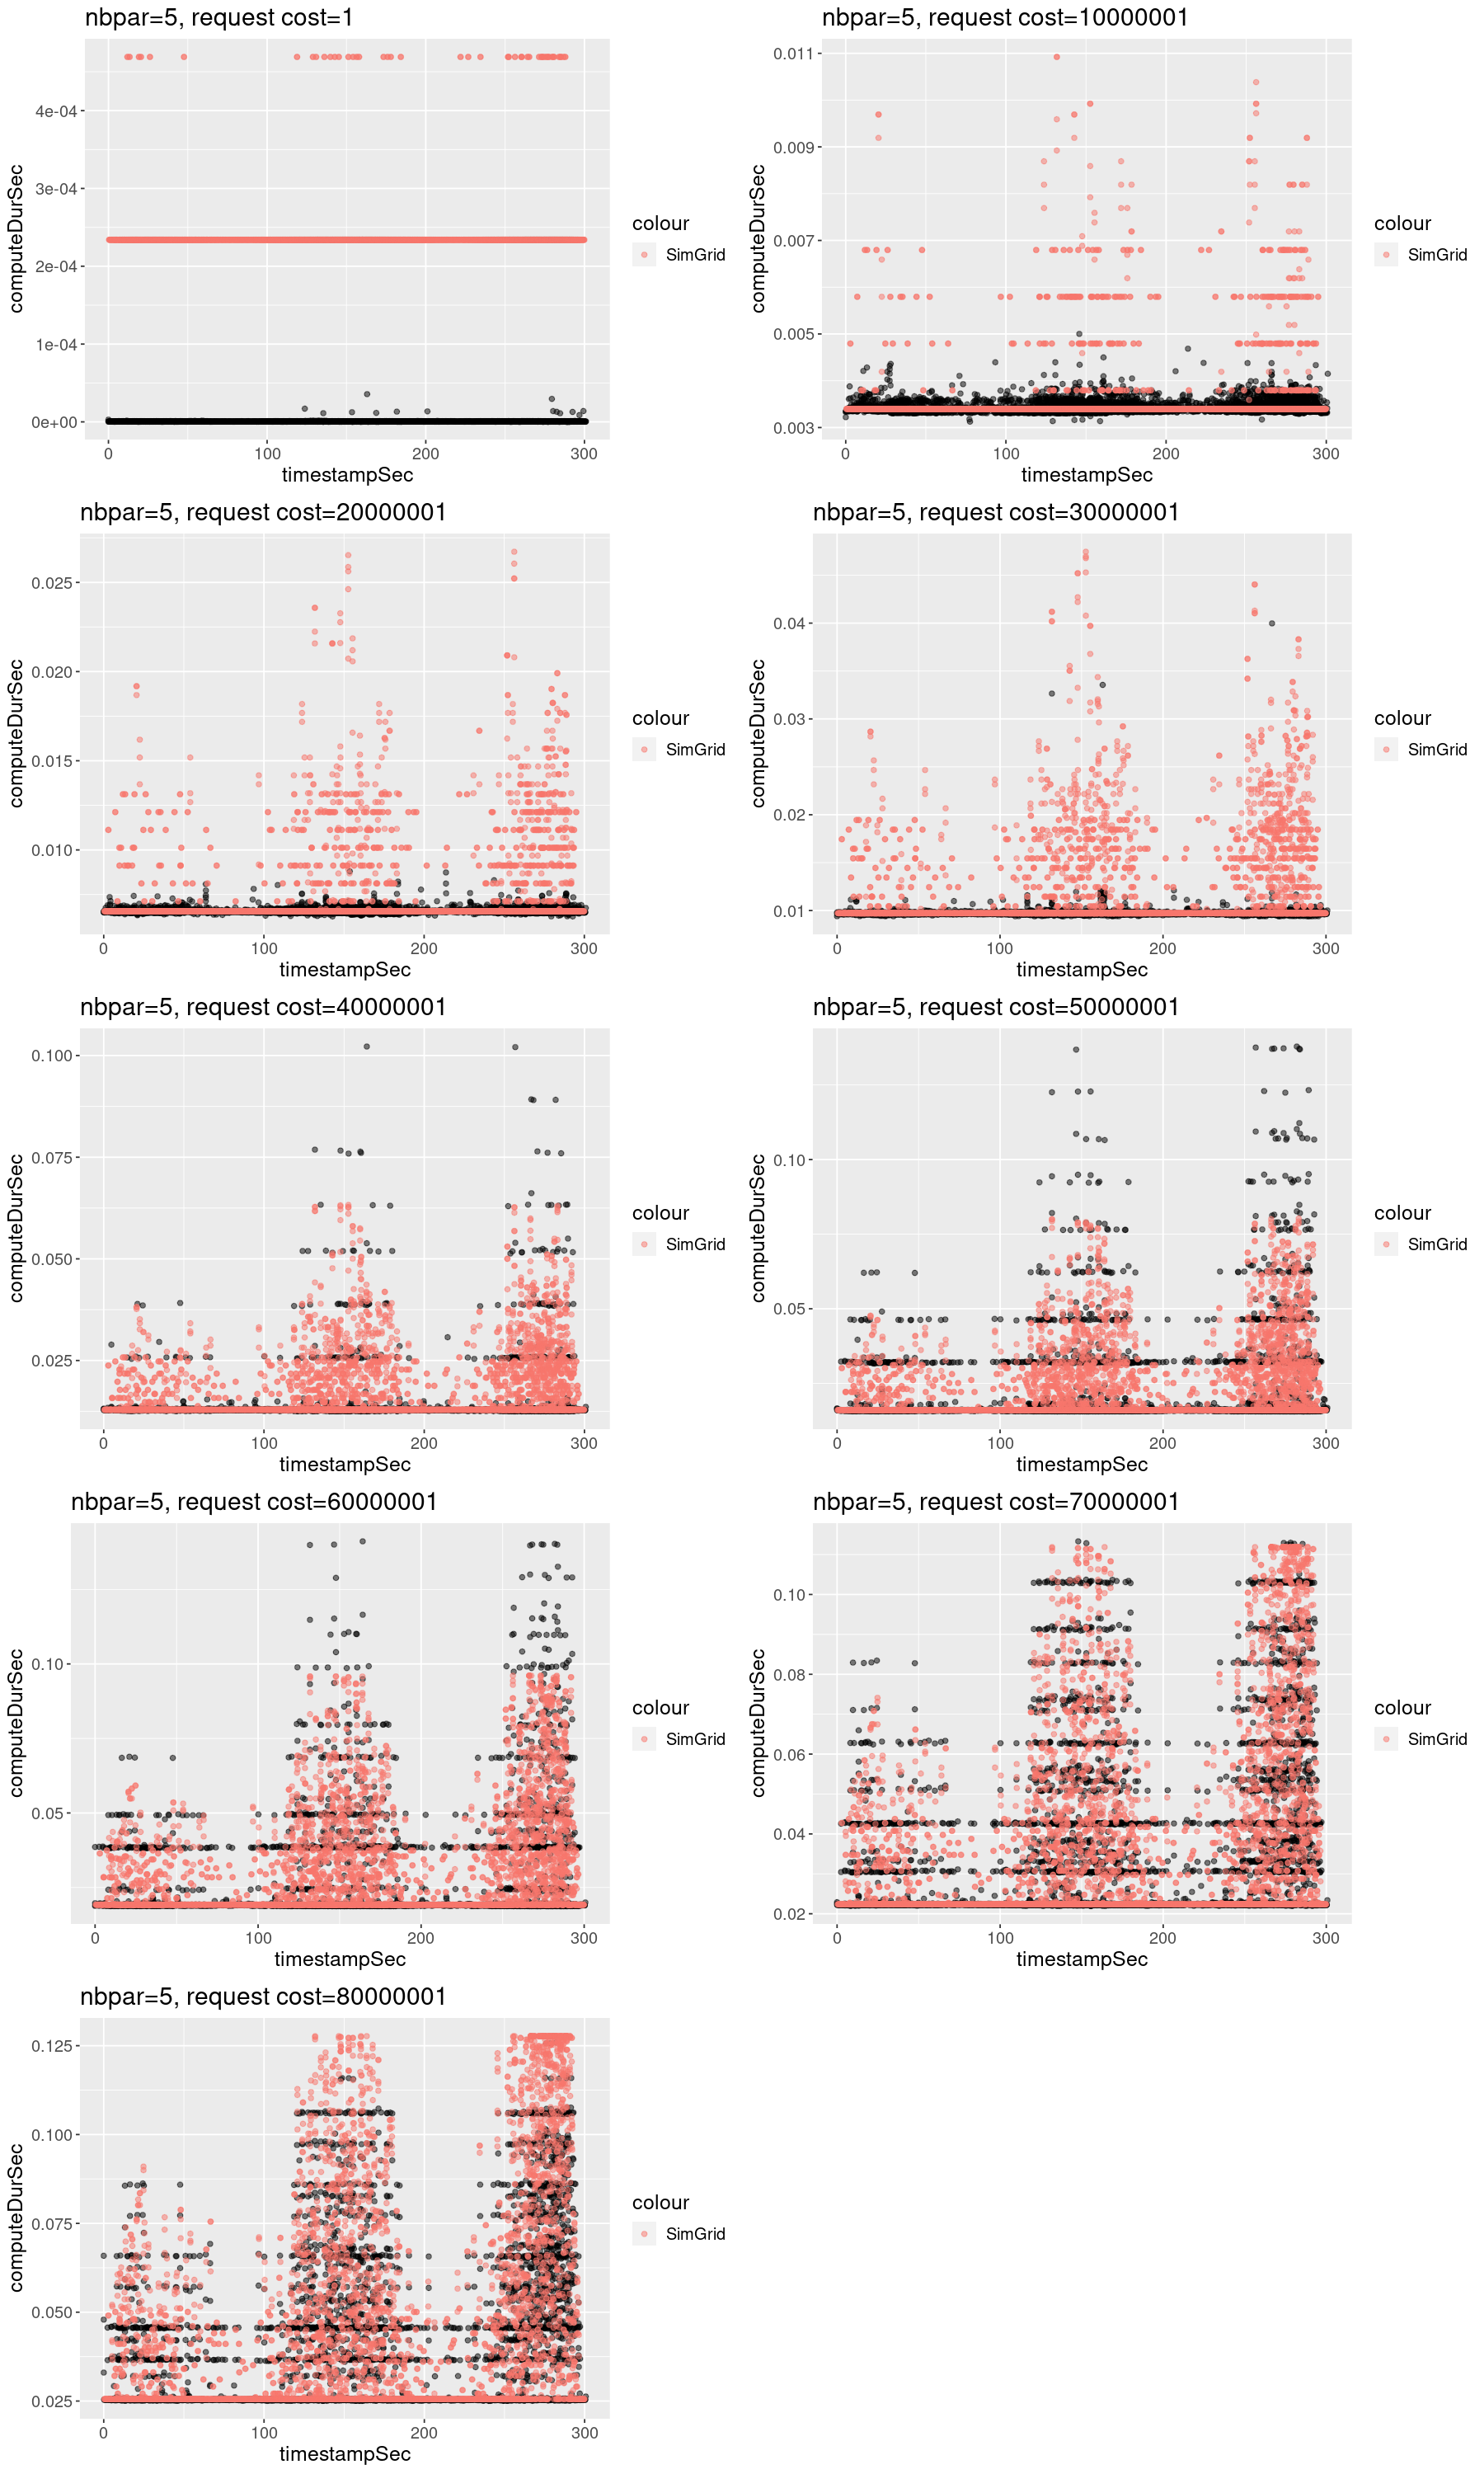

In [46]:
data_SG_load <- as_tibble(read.csv("results_reprod/microbenchmarks/sg_load_scenario1_par5.csv"))

data_load_RW <- as_tibble(read.csv("results_reprod/microbenchmarks/0607_par5test_1sample/1_aggrResults_1-10000000-80000001_1.csv"))

# preprocess to obtain timestamps as seconds instead of microseconds
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9

options(repr.plot.width=15, repr.plot.height=25)

P <- list()
for(i in seq(from=1, to=90000000, by=10000000)){
    tmpsg <- subset(data_SG_load, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec),alpha = 0.5)+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx, colour="SimGrid"),alpha = 0.5)+
        labs(title=sprintf("nbpar=5, request cost=%d",i))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=2))


<a id='paper'></a>
# Visualization used in the paper 

In this figure, that we use in the paper, we can see both the ability of our model to share resources under a variable load, leading to higher execution times, and the effect of modifying the maximum concurrency degree: single requests will take longer to execute if the number of parallel executions is important.


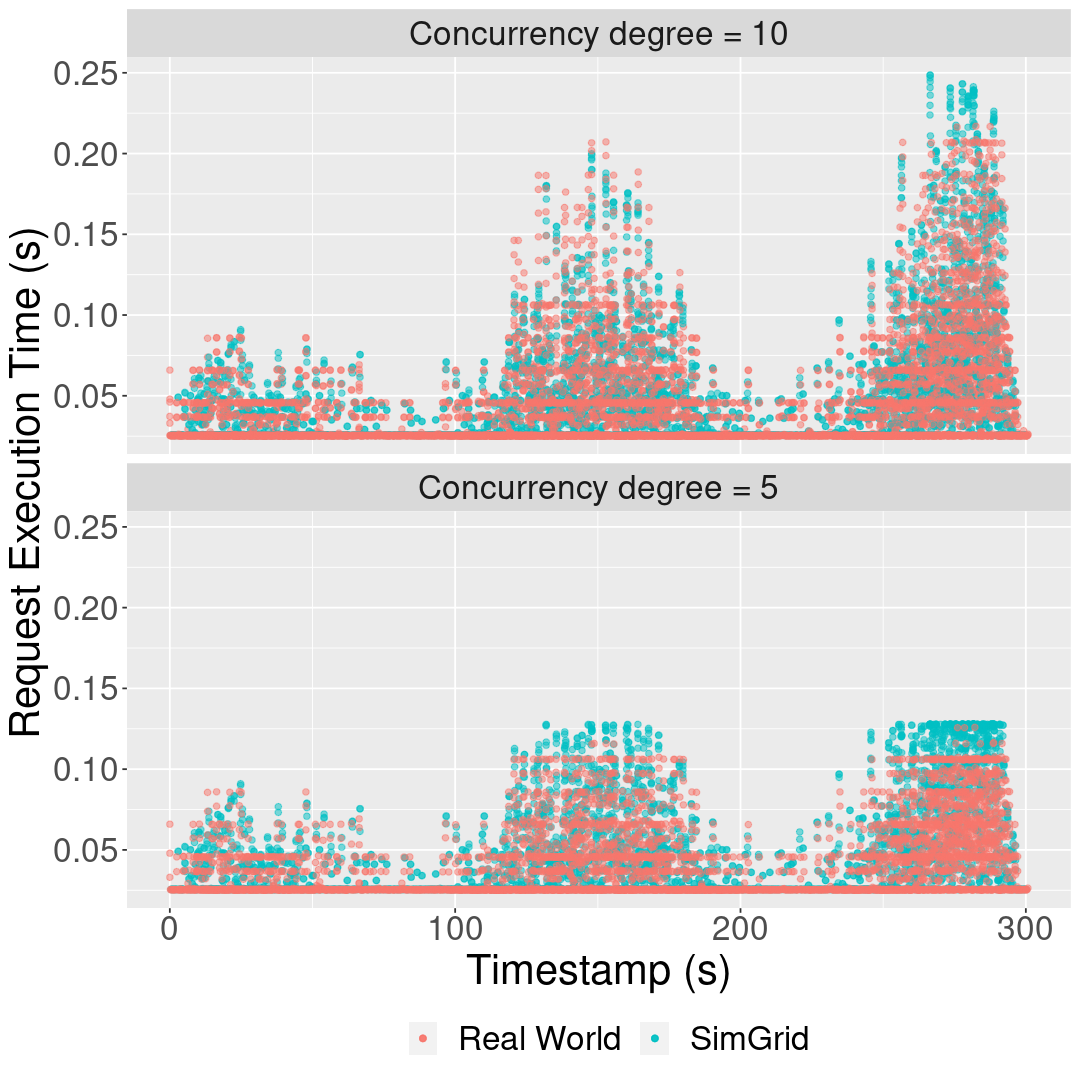

In [47]:

data_SG_load_p5 <- as_tibble(read.csv("results_reprod/microbenchmarks/sg_load_scenario1_par5.csv"))
data_SG_load_p5 <- subset(data_SG_load_p5, flops == trunc(nbIter_to_duration(80000001)*10^9))

data_load_RW_p5 <- as_tibble(read.csv("results_reprod/microbenchmarks/0607_par5test_1sample/1_aggrResults_1-10000000-80000001_1.csv"))
data_load_RW_p5$timestampSec <- as.numeric(as.character(data_load_RW_p5$timestamp)) / 1e9
data_load_RW_p5$computeDurSec <- as.numeric(as.character(data_load_RW_p5$computeDur)) / 1e9
data_load_RW_p5 <- subset(data_load_RW_p5, nbIter == 80000001)
data_SG_load_p5$parDeg <- "Concurrency degree = 5"


#summary(data_SG_load_p5)
data_SG_load_p10 <- as_tibble(read.csv("results_reprod/microbenchmarks/sg_load_scenario1_par10.csv"))
data_load_RW_p10 <- as_tibble(read.csv("results_reprod/microbenchmarks//0607_par10test_1sample/1_aggrResults_1-10000000-80000001_1.csv"))
data_SG_load_p10 <- subset(data_SG_load_p10, flops == trunc(nbIter_to_duration(80000001)*10^9))

data_load_RW_p10$timestampSec <- as.numeric(as.character(data_load_RW_p10$timestamp)) / 1e9
data_load_RW_p10$computeDurSec <- as.numeric(as.character(data_load_RW_p10$computeDur)) / 1e9
data_load_RW_p10$parDeg <- "Concurrency degree = 10"
data_SG_load_p10$parDeg <- "Concurrency degree = 10"
data_load_RW_p10 <- subset(data_load_RW_p10, nbIter == 80000001)
#summary(data_SG_load_p10)
options(repr.plot.width=9, repr.plot.height=9)

g <- ggplot() +
    geom_point(data = data_SG_load_p5, aes(x=ts, y=endEx-startEx,colour="SimGrid"),alpha = .5)+
    geom_point(data = data_load_RW_p5, aes(x=timestampSec, y=computeDurSec, colour="Real World"),alpha=.5)+
    geom_point(data = data_SG_load_p10, aes(x=ts, y=endEx-startEx, colour="SimGrid"),alpha = .5)+
    geom_point(data = data_load_RW_p10, aes(x=timestampSec, y=computeDurSec,colour="Real World"),alpha=.5)+

    facet_wrap("parDeg",ncol=1)+
    theme(legend.position = "bottom")+
        labs(y="Request Execution Time (s)", x="Timestamp (s)", color="")+

  theme(text = element_text(size = 25))

g

ggsave("plotMicrobench_final.pdf", width=9, height=9)